In [1]:
import sys
sys.path.append('../')

import dcor
from matplotlib import pyplot as plt
from npeet import entropy_estimators as npeet
import numpy as np
from scipy.stats import spearmanr
from scipy.special import beta, digamma, gamma
from sklearn.feature_selection import mutual_info_regression as sklearn_mi
from sklearn.utils import resample

# Sample Bivariate Normal

In [2]:
# Bivariate normal mutual information
def analytical_normal_mi(correlation):
    return -0.5*np.log(1 - correlation**2)

In [3]:
def sample_bivariate_standard_normal(correlation, n_samples):
    mean = [0, 0]
    cov = [[1, correlation],
                [correlation, 1]]
    return np.random.multivariate_normal(mean, cov, size=n_samples)

In [4]:
# Low nearest neighbors gives low bias but higher variance
# High nearest neigbors gives high bias but lower variance
# Recommended value by both Kraskov and NPEET is 3
def numerical_normal_mi(correlation, n_samples, replicates=1000, method="sklearn"):
    mi_array = []
    for _ in range(replicates):
        samples = sample_bivariate_standard_normal(correlation, n_samples)
        if method == "sklearn":
            mi_array.append(sklearn_mi(samples[:,0].reshape(-1,1), samples[:,1], n_neighbors=3)[0])
        elif method == "npeet":
            # LNC correction with k=3
            mi_array.append(npeet.mi(samples[:,0], samples[:,1], k=3, base=np.e, alpha=0.182223965479))
        else:
            raise NotImplementedError
    mi = np.mean(mi_array)
    mi_stdev = np.std(mi_array)
    return mi, mi_stdev

In [5]:
def compare_normal_mi(correlations = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.99, 0.999, 0.9999],
                                            samples_array = [30, 50, 100, 150, 200],
                                            replicates=1000):
    plt.subplots(nrows=3, ncols=3, sharey="row", figsize=(12,12))
    plt.suptitle('Estimation of Mutual Information for Normal Distribution\n', fontsize=16)
    for i, corr in enumerate(correlations, start=1):
        sklearn_mi = []
        npeet_mi = []
        mi_analytical = analytical_normal_mi(corr)
        # Get numerical estimates
        for samples in samples_array:
            sklearn_mi.append(numerical_normal_mi(corr, n_samples=samples, replicates=replicates, method="sklearn"))
            npeet_mi.append(numerical_normal_mi(corr, n_samples=samples, replicates=replicates, method="npeet"))
        # Convert to array
        sklearn_mi = np.array(sklearn_mi)
        npeet_mi = np.array(npeet_mi)
        # Plot
        plt.subplot(3,3,i)
        plt.errorbar(samples_array, sklearn_mi[:,0], yerr=sklearn_mi[:,1], fmt="--", label='sklearn', capsize=5)
        plt.errorbar(samples_array, npeet_mi[:,0], yerr=npeet_mi[:,1], fmt="--", label='npeet', capsize=5)
        plt.axhline(mi_analytical, c='purple', label="analytical")
        plt.xlabel("Number of samples")
        plt.ylabel('Mutual information')
        plt.legend()
        plt.title(f"Correlation: {corr}")
        plt.tight_layout()
        #plt.suptitle(
        #    'Estimation of Mutual Information for Student with degree of freedom {}\n\n'
        #    .format(dof), fontsize=16)
        #plt.show()

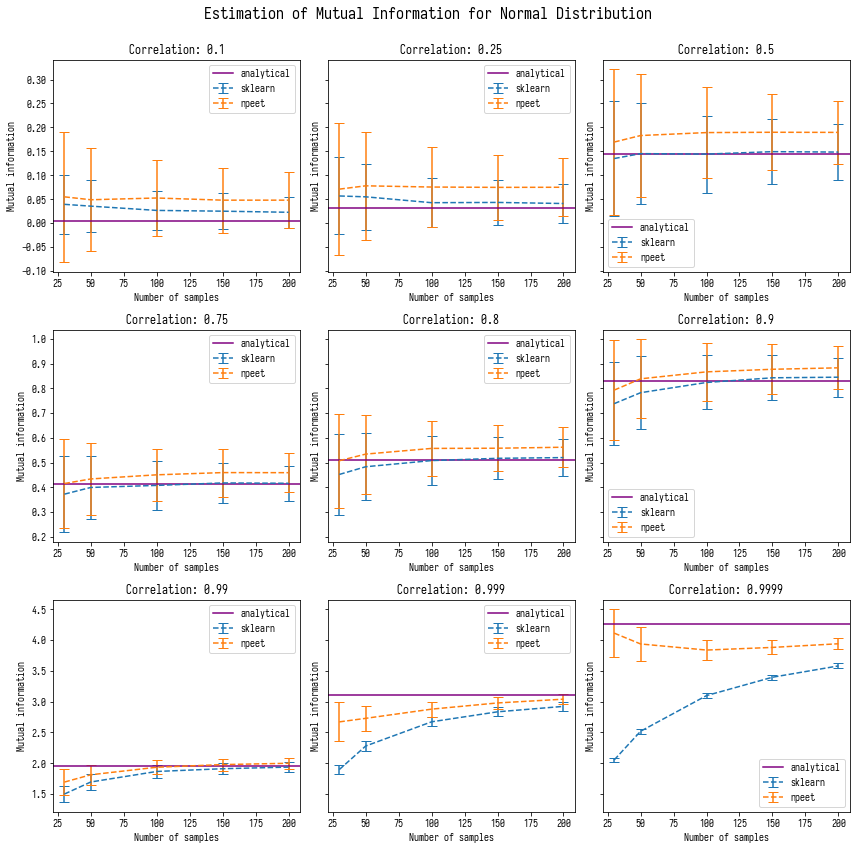

In [1278]:
compare_normal_mi(replicates=1000)

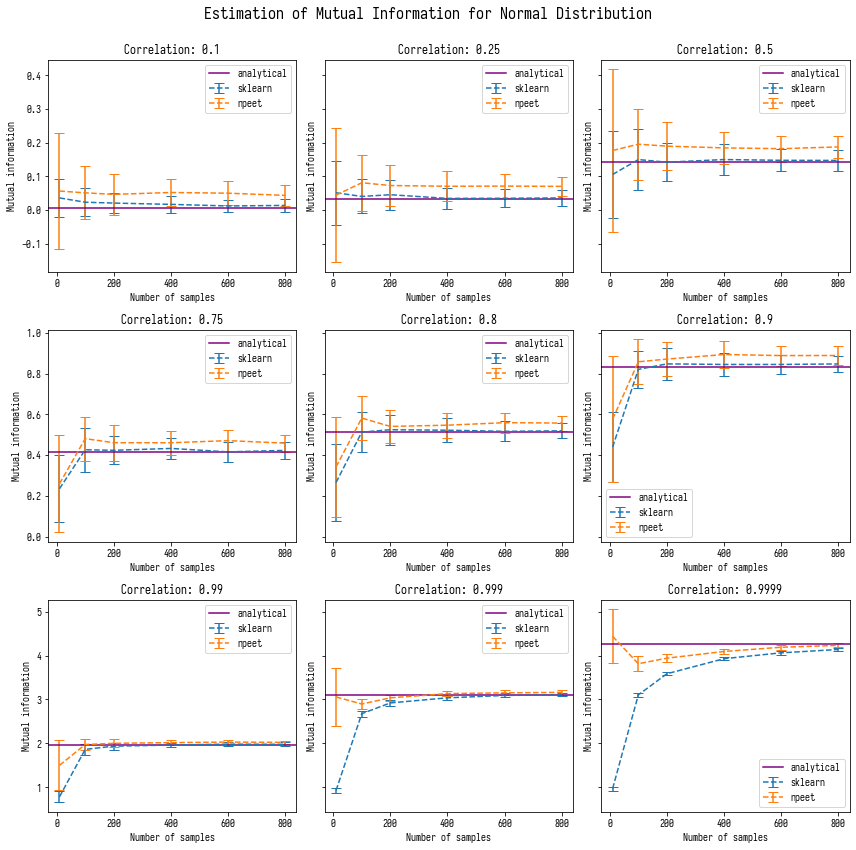

In [1277]:
compare_normal_mi(samples_array = [10, 100, 200, 400, 600, 800], replicates=100)

Error bars are ±1 s.d. based on multiple replicates

Conclusion: it doesn't make sense to take npeet mutual information further, as it is noisier than vanilla sklearn implementation, and the correction only applies at correlation levels unrealistic to real data.

## Signal to noise ratio at different sample sizes

In [6]:
# Mutual information to absolute value of correlation
def mi_to_correlation(mi):
    return np.sqrt(1 - np.exp(-2*mi))

In [82]:
def get_mi_snr(mi_array, n_samples, n_replicates=1000):
    correlation_array = mi_to_correlation(mi_array)
    snr_list = []
    for correlation in correlation_array:
        mean, std = numerical_normal_mi(correlation, n_samples, replicates=n_replicates, method="sklearn")
        snr_list.append(mean/std)
    return np.array(snr_list)

In [83]:
def plot_mi_snr():
    n_samples_list = [1000, 500, 200, 100, 30]
    mi_array = np.arange(0, 2.1, 0.2)
    for n_samples in n_samples_list:
        snr_array = get_mi_snr(mi_array, n_samples, n_replicates=1000)
        plt.plot(mi_array, snr_array, "-o")
    legend_list = [f"{s} samples" for s in n_samples_list]
    plt.legend(legend_list)
    plt.xlabel("Analytical Mutual Information")
    plt.ylabel("SNR")
    plt.title("Signal to noise for sklearn mutual information")

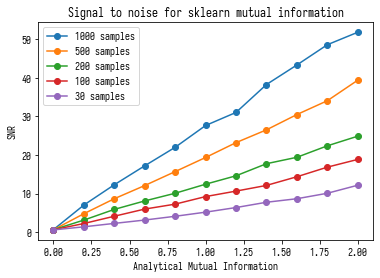

In [81]:
plot_mi_snr()

Signal to noise is linear, so noise is constant for a given number of samples.

In [21]:
def get_mi_average_noise(mi_array, n_samples, n_replicates=1000):
    correlation_array = mi_to_correlation(mi_array)
    sigma_list = []
    for correlation in correlation_array:
        _, std = numerical_normal_mi(correlation, n_samples, replicates=n_replicates, method="sklearn")
        sigma_list.append(std)
    return np.mean(sigma_list)

In [84]:
def plot_noise_vs_samples():
    n_samples_list = [30, 100, 200, 500, 1000, 2500, 5000, 7500, 10000]
    mi_array = np.arange(0, 2.1, 0.1)
    noise_list = []
    for n_samples in n_samples_list:
        noise_list.append(get_mi_average_noise(mi_array, n_samples, n_replicates=100))
    plt.figure()
    plt.plot(n_samples_list, noise_list, "-o")
    plt.xlabel("Number of Samples")
    plt.ylabel(r"$\sigma_{MI}$")
    plt.title("Uncertainty in sklearn mutual information")
    plt.figure()
    plt.bar([str(n) for n in n_samples_list], 2*np.array(noise_list))
    plt.xlabel("Number of Samples")
    plt.ylabel(r"Resolution ($2 \sigma_{MI}$)")
    plt.title("Resolution of sklearn mutual information")

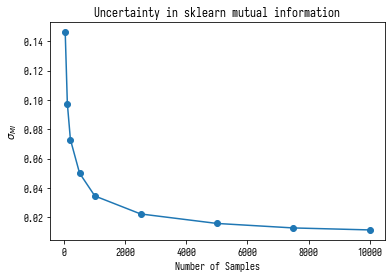

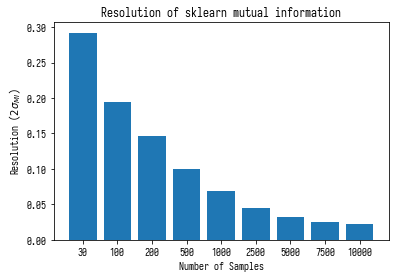

In [85]:
plot_noise_vs_samples()

Resolution is the minimum difference in mutual information (in nats) that reliably can be resolved at the given number of samples.

# Sample bivariate student T

In [1013]:
# Bivariate student T mutual information
def analytical_student_mi(rho, nu):
    normal_component = analytical_normal_mi(rho)
    gamma_component = 2*np.log(
        np.sqrt(nu/(2*np.pi))
        * beta(nu/2, 0.5)
    )

    digamma_component = (
        - (2 + nu)/nu
        + (1 + nu) * (digamma((nu + 1)/2) - digamma(nu/2))
    )
    return normal_component + gamma_component + digamma_component

In [348]:
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = np.ones(n)
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal

In [357]:
def sample_bivariate_standard_student(pseudo_correlation, degrees_of_freedom, n_samples):
    mean = [0, 0]
    sigma = [[1, pseudo_correlation],
                [pseudo_correlation, 1]]
    return multivariate_t_rvs(mean, sigma, df=degrees_of_freedom, n=n_samples)

In [586]:
sample = sample_bivariate_standard_student(0.25, 1, 100)

0.22417142752923624
0.21352118038015178
0.24956938367670745
0.493146733019077


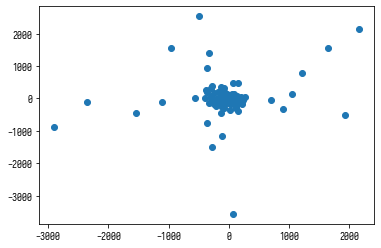

In [1071]:
samples = sample_bivariate_standard_student(0, 1, 10000)
plt.scatter(samples[:,0], samples[:,1])
print(analytical_student_mi(0, 1))
print(sklearn_mi(samples[:,0].reshape(-1,1), samples[:,1], n_neighbors=3)[0])
print(npeet.mi(samples[:,0], samples[:,1], k=3, base=np.e, alpha=0.182223965479))
print(dcor.distance_correlation(samples[:,0], samples[:,1]))

In [950]:
samples[:,0]

array([-0.69619416,  1.03712358,  0.13610624, ...,  0.47235472,
        2.04272906,  0.58746879])

# Pathological Datasets

In [789]:
from scipy.spatial import distance

rs = np.random.RandomState(seed=0)

def mysubplot(x, y, numRows, numCols, plotNum,
              xlim=(-4, 4), ylim=(-4, 4)):

    r = np.corrcoef(x, y)[0, 1]
    d_r = dcor.distance_correlation(x,y)
    mi_sk = sklearn_mi(x.reshape(-1,1), y, n_neighbors=3)[0]
    mi_npeet = npeet.mi(x,y, k=3, base=np.e, alpha=0.182223965479)
    ax = plt.subplot(numRows, numCols, plotNum,
                     xlim=xlim, ylim=ylim)
    ax.set_title(f"r: {r:.1f}\ndcorr: {d_r:.2f}\nsklearn: {mi_sk:.2f}\nnpeet: {mi_npeet:.2f}", fontsize=10)
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.plot(x, y, ',')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def rotation(xy, t):
    return np.dot(xy, [[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

def mvnormal(n=1000):
    cors = [1.0, 0.8, 0.4, 0.0, -0.4, -0.8, -1.0]
    for i, cor in enumerate(cors):
        cov = [[1, cor],[cor, 1]]
        xy = rs.multivariate_normal([0, 0], cov, n)
        mysubplot(xy[:, 0], xy[:, 1], 4, 7, i+1)

def rotnormal(n=1000):
    ts = [0, np.pi/12, np.pi/6, np.pi/4, np.pi/2-np.pi/6,
          np.pi/2-np.pi/12, np.pi/2]
    cov = [[1, 1],[1, 1]]
    xy = rs.multivariate_normal([0, 0], cov, n)
    for i, t in enumerate(ts):
        xy_r = rotation(xy, t)
        mysubplot(xy_r[:, 0], xy_r[:, 1], 4, 7, i+8)

def others(n=1000):
    x = rs.uniform(-1, 1, n)
    y = 4*(x**2-0.5)**2 + rs.uniform(-1, 1, n)/3
    mysubplot(x, y, 4, 7, 15, (-1, 1), (-1/3, 1+1/3))

    y = rs.uniform(-1, 1, n)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2+np.sqrt(2)) / np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 4, 7, 16, (-lim, lim), (-lim, lim))

    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 4, 7, 17, (-lim, lim), (-lim, lim))

    y = 2*x**2 + rs.uniform(-1, 1, n)
    mysubplot(x, y, 4, 7, 18, (-1, 1), (-1, 3))

    y = (x**2 + rs.uniform(0, 0.5, n)) * \
        np.array([-1, 1])[rs.random_integers(0, 1, size=n)]
    mysubplot(x, y, 4, 7, 19, (-1.5, 1.5), (-1.5, 1.5))

    y = np.cos(x * np.pi) + rs.uniform(0, 1/8, n)
    x = np.sin(x * np.pi) + rs.uniform(0, 1/8, n)
    mysubplot(x, y, 4, 7, 20, (-1.5, 1.5), (-1.5, 1.5))

    xy1 = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], int(n/4))
    xy2 = np.random.multivariate_normal([-3, 3], [[1, 0], [0, 1]], int(n/4))
    xy3 = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], int(n/4))
    xy4 = np.random.multivariate_normal([3, -3], [[1, 0], [0, 1]], int(n/4))
    xy = np.concatenate((xy1, xy2, xy3, xy4), axis=0)
    mysubplot(xy[:, 0], xy[:, 1], 4, 7, 21, (-7, 7), (-7, 7))
    
def others_scaled(n=1000):
    x = rs.uniform(-1, 1, n)
    y = 4*(x**2-0.5)**2 + rs.uniform(-0.1, 0.1, n)
    mysubplot(x, y, 4, 7, 22, (-1, 1), (-1/3, 1+1/3))

    y = rs.uniform(-1, 1, n)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2+np.sqrt(2)) / np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1]/10, 4, 7, 23, (-lim, lim), (-lim, lim))

    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1]/10, 4, 7, 24, (-lim, lim), (-lim, lim))

    y = 2*x**2 + rs.uniform(-0.1, 0.1, n)
    mysubplot(x, y, 4, 7, 25, (-1, 1), (-1, 3))

    y = (x**2 + rs.uniform(0, 0.05, n)) * \
        np.array([-1, 1])[rs.random_integers(0, 1, size=n)]
    mysubplot(x, y, 4, 7, 26, (-1.5, 1.5), (-1.5, 1.5))

    y = np.cos(x * np.pi) + rs.uniform(0, 1/80, n)
    x = np.sin(x * np.pi) + rs.uniform(0, 1/80, n)
    mysubplot(x, y, 4, 7, 27, (-1.5, 1.5), (-1.5, 1.5))

    xy1 = np.random.multivariate_normal([3, 3], [[.1, 0], [0, .1]], int(n/4))
    xy2 = np.random.multivariate_normal([-3, 3], [[.1, 0], [0, .1]], int(n/4))
    xy3 = np.random.multivariate_normal([-3, -3], [[.1, 0], [0, .1]], int(n/4))
    xy4 = np.random.multivariate_normal([3, -3], [[.1, 0], [0, .1]], int(n/4))
    xy = np.concatenate((xy1, xy2, xy3, xy4), axis=0)
    mysubplot(xy[:, 0], xy[:, 1], 4, 7, 28, (-7, 7), (-7, 7))

/var/folders/v_/s2wx6q8d189d5hs7nf38yz8r0000gn/T/ipykernel_13622/3670451751.py:61: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  np.array([-1, 1])[rs.random_integers(0, 1, size=n)]
/var/folders/v_/s2wx6q8d189d5hs7nf38yz8r0000gn/T/ipykernel_13622/3670451751.py:94: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  np.array([-1, 1])[rs.random_integers(0, 1, size=n)]


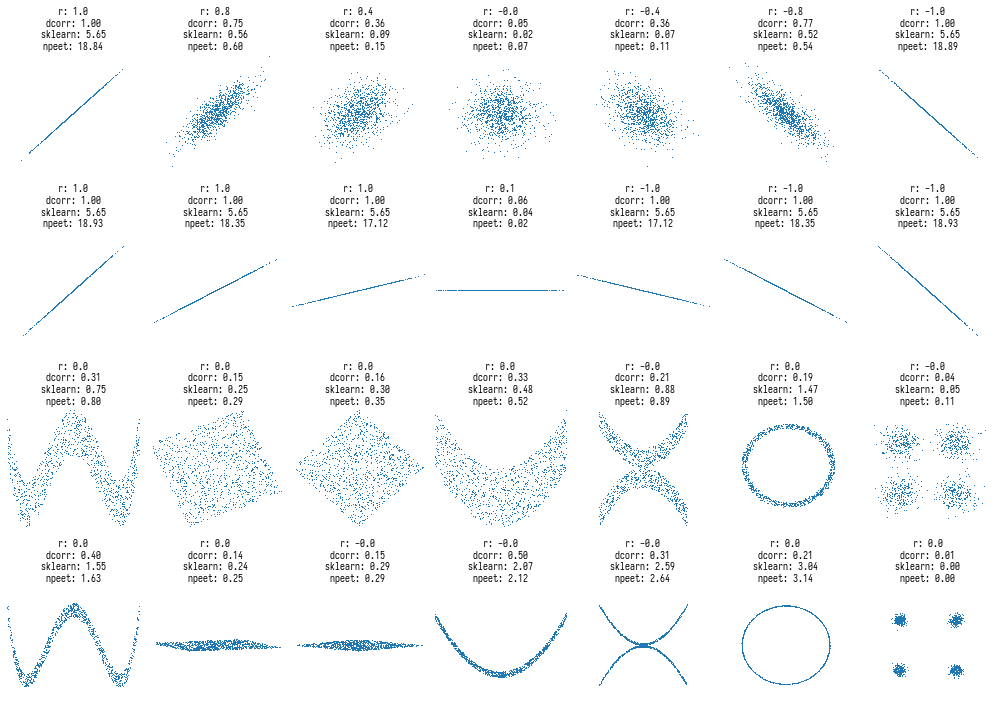

In [790]:
plt.figure(facecolor='white', figsize=(14,10))
mvnormal(n=1000)
rotnormal(n=1000)
others(n=1000)
others_scaled(n=1000)
plt.tight_layout()
plt.show()

Each subplot contains 1000 samples